Importing the required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import explained_variance_score,r2_score
from time import time
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from datetime import datetime, date
import calendar
import holidays
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, Ridge
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Loading the dataset into a python dataframe

In [2]:
df = pd.read_csv('train.csv')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [3]:
df.shape

(913000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [7]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')

train = df[(df["year"] != 2017) & (df["store"] == 1) & (df["item"] == 1)]

test = df[(df["year"] == 2017) & (df["store"] == 1) & (df["item"] == 1)]

In [8]:
print(train)
print(test)

            date  store  item  sales  year
0     2013-01-01      1     1     13  2013
1     2013-01-02      1     1     11  2013
2     2013-01-03      1     1     14  2013
3     2013-01-04      1     1     13  2013
4     2013-01-05      1     1     10  2013
...          ...    ...   ...    ...   ...
1456  2016-12-27      1     1     10  2016
1457  2016-12-28      1     1     16  2016
1458  2016-12-29      1     1     21  2016
1459  2016-12-30      1     1     24  2016
1460  2016-12-31      1     1     14  2016

[1461 rows x 5 columns]
            date  store  item  sales  year
1461  2017-01-01      1     1     19  2017
1462  2017-01-02      1     1     15  2017
1463  2017-01-03      1     1     10  2017
1464  2017-01-04      1     1     16  2017
1465  2017-01-05      1     1     14  2017
...          ...    ...   ...    ...   ...
1821  2017-12-27      1     1     14  2017
1822  2017-12-28      1     1     19  2017
1823  2017-12-29      1     1     15  2017
1824  2017-12-30      1     1

Data Pre-Processing

In [9]:
train["month_day"] = train.date.map(lambda x:str(x)[5:12])

In [10]:
train = train[train["month_day"] != '02-29']

In [11]:
X_Pred = train.groupby("month_day").sales.mean().to_frame()

In [12]:
X_Test = test[["sales"]]

In [13]:
mape(X_Pred, X_Test)

0.3029780598276817

Feature Engineering


In [14]:
#Splitting the Date coumn into Year, Month and Day respectively
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [15]:
#Adding weekend column
def weekend_or_weekday(year,month,day):

    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0

df['weekend'] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [16]:
#Adding columns to capture cyclic nature of the data (if any)
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,weekend,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0.5,0.866025


In [17]:
#Adding column to identify the day of the week
def which_day(year, month, day):

    d = datetime(year,month,day)
    return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],
                                                      x['month'],
                                                      x['day']),
                                   axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0.5,0.866025,5


In [18]:
df.drop('date', axis=1, inplace=True)

Exploratory Data Analysis

In [19]:
df['store'].nunique(), df['item'].nunique()
#Result implies 10 unique stores and they sell 50 different products

(10, 50)

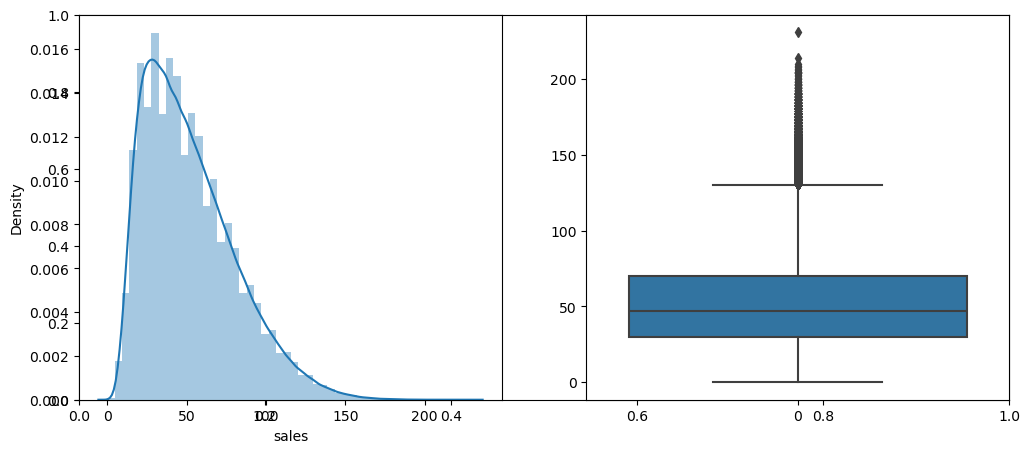

In [20]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

In [21]:
df = df[df['sales']<140]

In [22]:
train = df[(df["year"] != 2017) & (df["store"] == 1) & (df["item"] == 1)]

test = df[(df["year"] == 2017) & (df["store"] == 1) & (df["item"] == 1)]

X_train = train.drop(['sales', 'year'], axis=1)

X_test = test.drop(['sales', 'year'], axis=1)

y_train = train['sales'].values

y_test = test['sales'].values

X_train.shape, X_test.shape

((1461, 8), (365, 8))

In [23]:
X_train

,store,item,month,day,weekend,m1,m2,weekday
0,1,1,1,1,0,5.000000e-01,0.866025,1
1,1,1,1,2,0,5.000000e-01,0.866025,2
2,1,1,1,3,0,5.000000e-01,0.866025,3
3,1,1,1,4,0,5.000000e-01,0.866025,4
4,1,1,1,5,1,5.000000e-01,0.866025,5
...,...,...,...,...,...,...,...,...
1456,1,1,12,27,0,-2.449294e-16,1.000000,1
1457,1,1,12,28,0,-2.449294e-16,1.000000,2
1458,1,1,12,29,0,-2.449294e-16,1.000000,3
1459,1,1,12,30,0,-2.449294e-16,1.000000,4


In [24]:
# Standardization the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training the dataset on different models

In [25]:
regressors = [
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    XGBRegressor(),
    Lasso(),
    Ridge()
]

In [26]:
threshold = 15
y_train_01 = np.where(y_train > threshold, 1, 0)
y_test_01 = np.where(y_test > threshold, 1, 0)

KNeighborsRegressor()
	Training time: 0.006s
	Prediction time: 0.003s
	Explained variance: 0.04600716802578542
	Mean absolute percentage error: 0.9670927266056953
	R2 score: -9.512568860155621


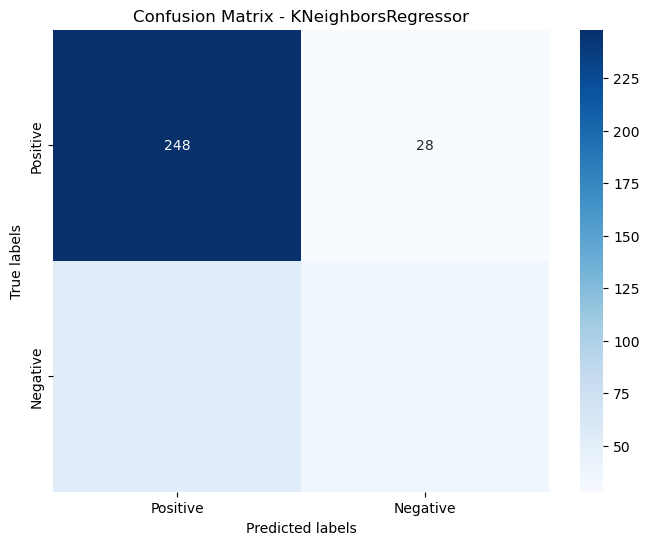

Classification Report:


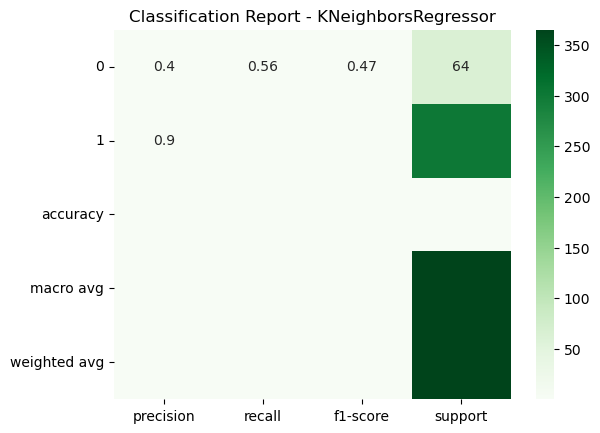


ExtraTreesRegressor()
	Training time: 0.184s
	Prediction time: 0.015s
	Explained variance: 0.03972072674727256
	Mean absolute percentage error: 0.9660542259967977
	R2 score: -9.510805923257726


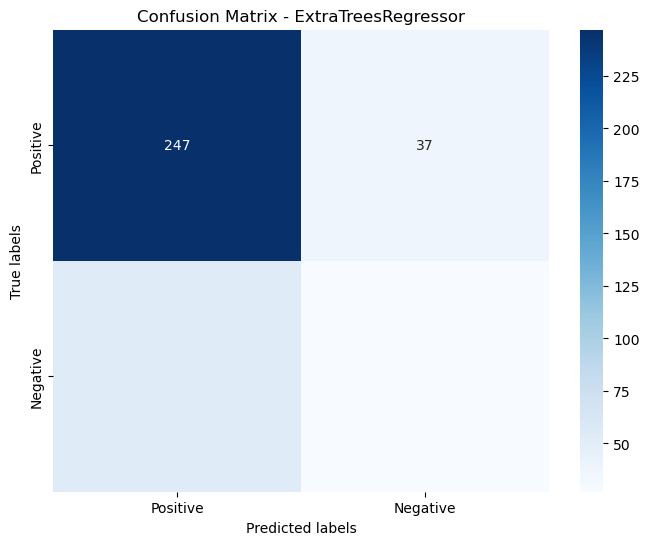

Classification Report:


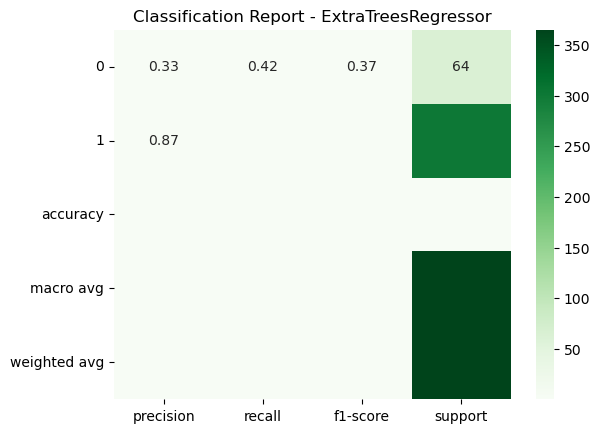


RandomForestRegressor()
	Training time: 0.247s
	Prediction time: 0.013s
	Explained variance: 0.04224351905791324
	Mean absolute percentage error: 0.9662881798096763
	R2 score: -9.50913669213762


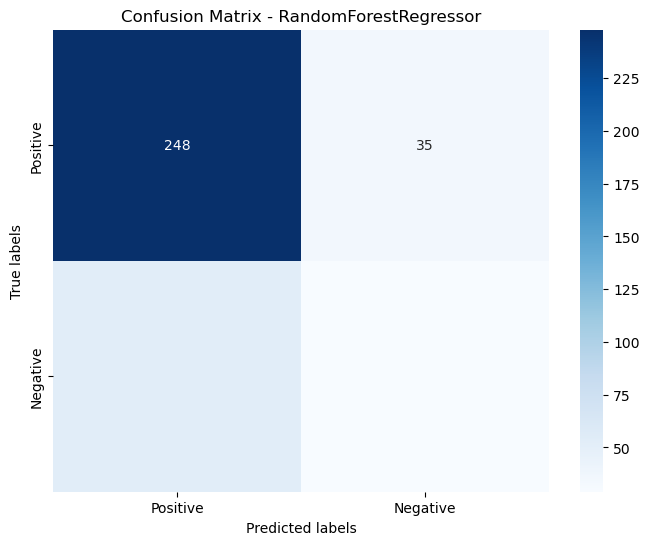

Classification Report:


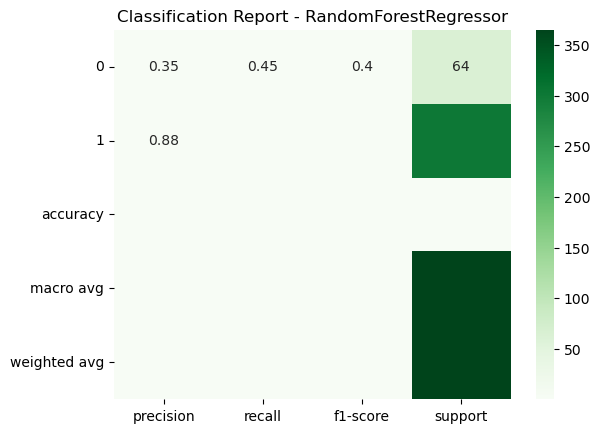


GradientBoostingRegressor()
	Training time: 0.096s
	Prediction time: 0.000s
	Explained variance: 0.04746637471716597
	Mean absolute percentage error: 0.9672179368078285
	R2 score: -9.513703714762206


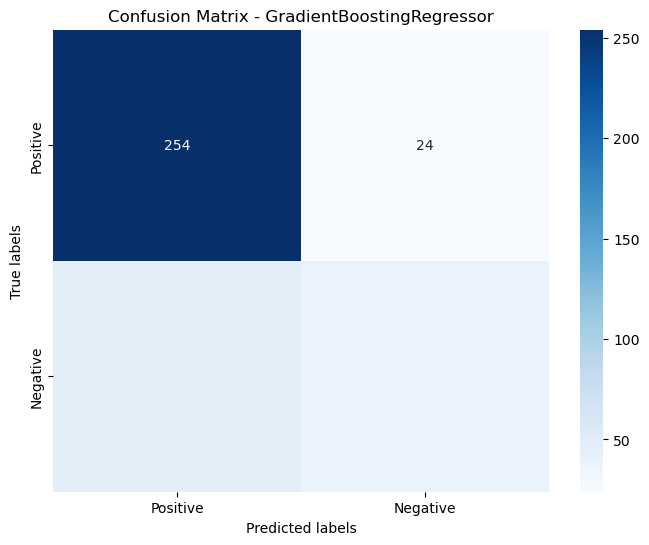

Classification Report:


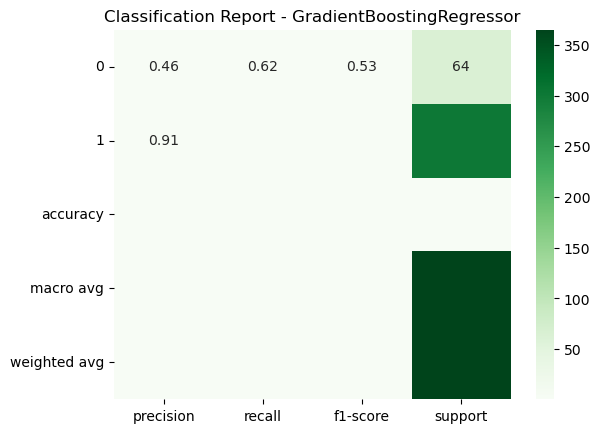


DecisionTreeRegressor()
	Training time: 0.000s
	Prediction time: 0.000s
	Explained variance: 0.04057273217233026
	Mean absolute percentage error: 0.9662868122911545
	R2 score: -9.511173302637834


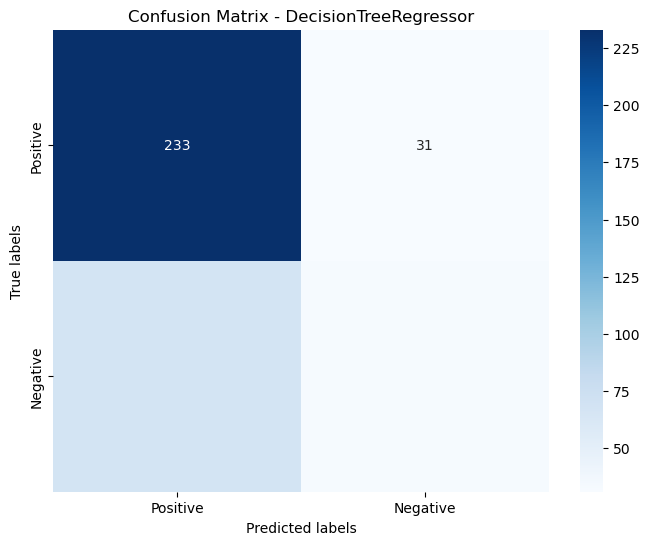

Classification Report:


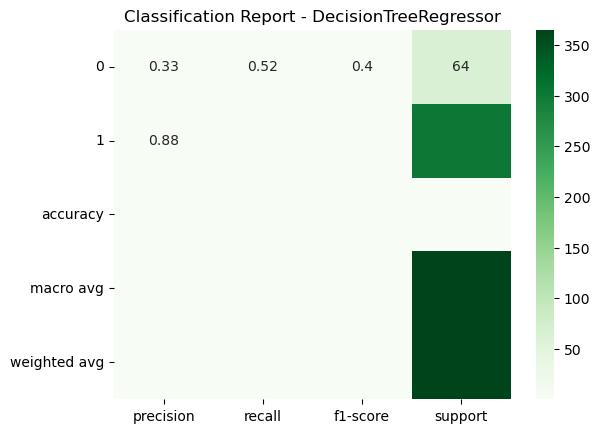


LinearRegression()
	Training time: 0.020s
	Prediction time: 0.000s
	Explained variance: 0.045297139414438026
	Mean absolute percentage error: 0.9668184281768291
	R2 score: -9.51550084383711


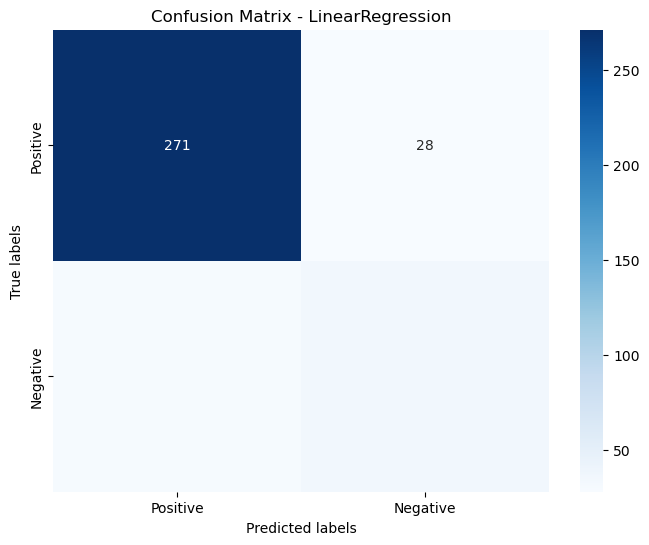

Classification Report:


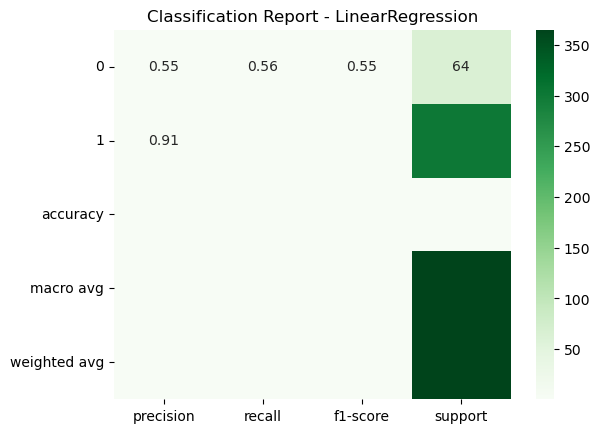


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
	Training time: 0.772s
	Prediction time: 0.002s
	Explained variance: 0.04258451912671679
	Mean absolute percentage error: 0.9657454827691347
	R2 score: -9.494905073865555


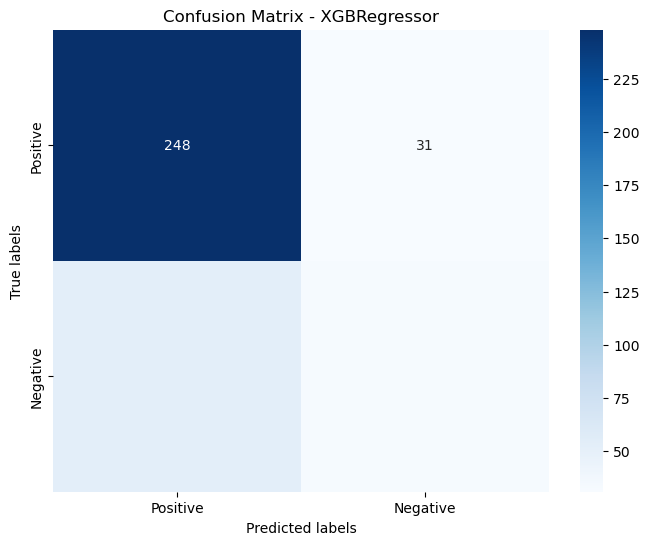

Classification Report:


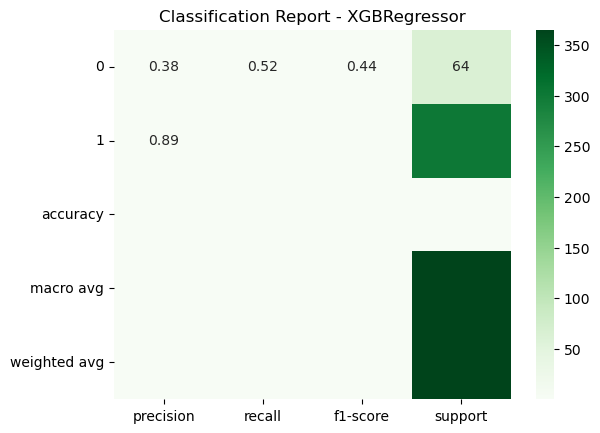


Lasso()
	Training time: 0.000s
	Prediction time: 0.000s
	Explained variance: 3.3306690738754696e-16
	Mean absolute percentage error: 0.9638886062236937
	R2 score: -9.561328550237455


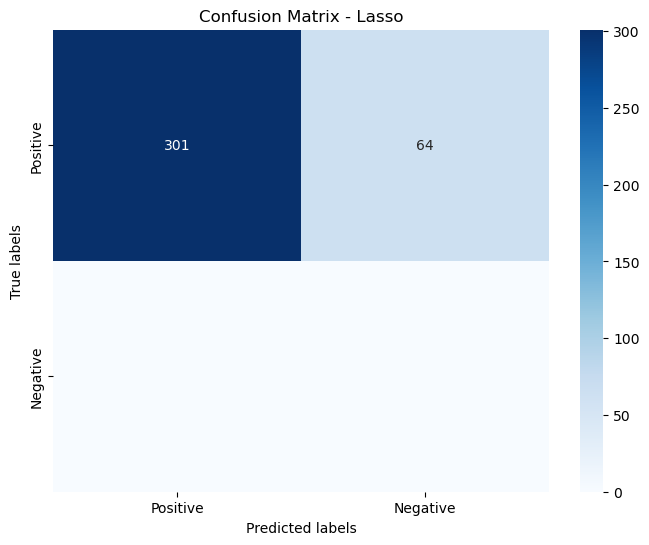

Classification Report:


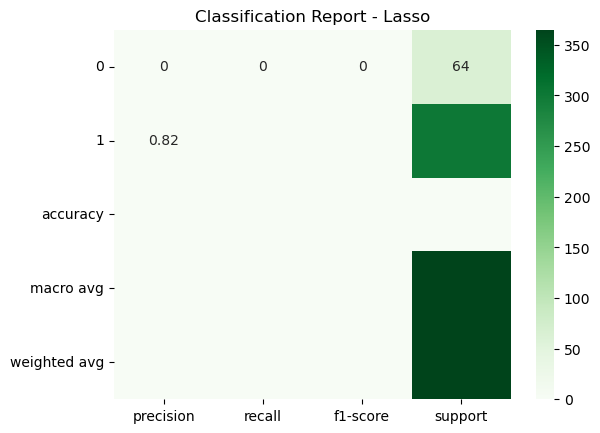


Ridge()
	Training time: 0.014s
	Prediction time: 0.000s
	Explained variance: 0.045267042608372554
	Mean absolute percentage error: 0.9668162757856753
	R2 score: -9.515531002122703


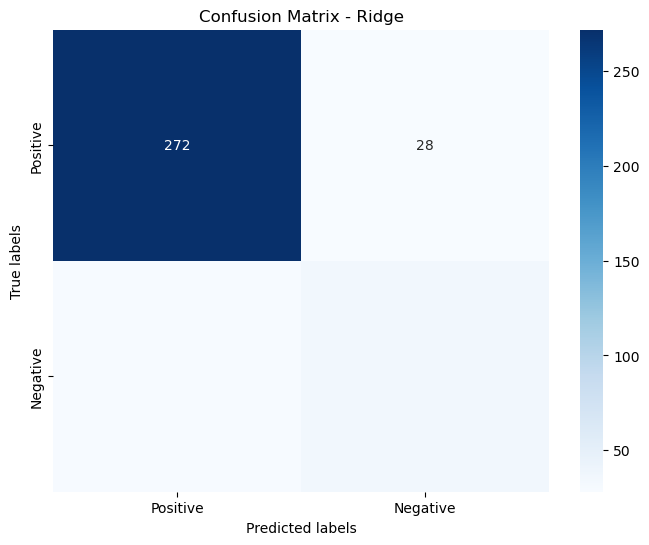

Classification Report:


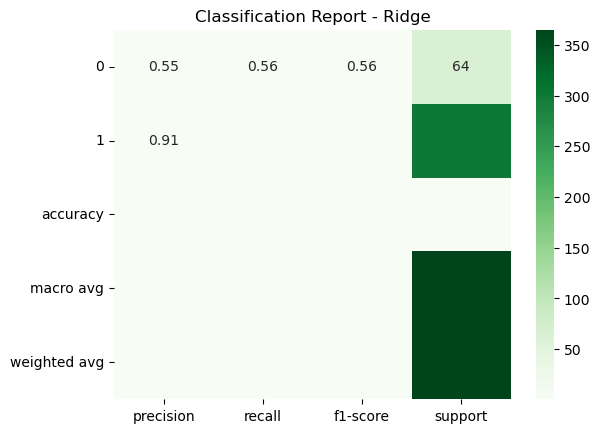

In [27]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train_01)  # Use binary labels for training
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute percentage error:", mape(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))

    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_01, y_pred_binary)  # Use binary labels for evaluation

    # Convert classification report to a dataframe for visualization
    cr_dict = classification_report(y_test_01, y_pred_binary, output_dict=True)
    cr_df = pd.DataFrame(cr_dict).transpose()

    # Plotting 2x2 confusion matrix
    tn, fp, fn, tp = cm.ravel()
    cm_2x2 = np.array([[tp, fp], [fn, tn]])  # Rearrange the matrix for a 2x2 format

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_2x2, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {type(model).__name__}")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([0.5, 1.5], labels=['Positive', 'Negative'])
    plt.yticks([0.5, 1.5], labels=['Positive', 'Negative'])
    plt.show()

    print("Classification Report:")
    sns.heatmap(cr_df, annot=True, cmap="Greens")
    plt.title(f"Classification Report - {type(model).__name__}")
    plt.show()
    print()

Results-: Gradient Boosting performed the best among all the models

In [28]:
parameters = { 'loss' : ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate' : (0.05,0.25,0.50,1),
              'criterion' : ['friedman_mse', 'mse', 'mae'],
              'max_features' : ['auto', 'sqrt', 'log2']
             }


In [29]:
grid = GridSearchCV(GradientBoostingRegressor(),parameters)
model = grid.fit(X_train,y_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'huber', 'max_features': 'sqrt'} 

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt') 



In [30]:
X_train

array([[ 0.        ,  0.        , -1.6014511 , ...,  0.71523725,
         1.22531488, -1.00085668],
       [ 0.        ,  0.        , -1.6014511 , ...,  0.71523725,
         1.22531488, -0.50042834],
       [ 0.        ,  0.        , -1.6014511 , ...,  0.71523725,
         1.22531488,  0.        ],
       ...,
       [ 0.        ,  0.        ,  1.58815364, ...,  0.00677945,
         1.41442871,  0.        ],
       [ 0.        ,  0.        ,  1.58815364, ...,  0.00677945,
         1.41442871,  0.50042834],
       [ 0.        ,  0.        ,  1.58815364, ...,  0.00677945,
         1.41442871,  1.00085668]])

In [32]:
start = time()
model = GradientBoostingRegressor(learning_rate=0.05, loss='squared_error', max_features='sqrt')
model.fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = model.predict(X_test)
predict_time = time()-start
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute percentage error:", mape(y_test, y_pred))
print("\tR2 score:", r2_score(y_test, y_pred))

GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt')
	Training time: 0.046s
	Prediction time: 0.000s
	Explained variance: 0.5214156449014653
	Mean absolute percentage error: 0.1965338551344615
	R2 score: 0.3633210053980176


In [33]:
all_models = {}

for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(learning_rate = 0.05, loss = 'squared_error', max_features = 'sqrt', alpha=alpha)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

all_models["mse"] = gbr.fit(X_train, y_train)

In [34]:
y_pred = all_models["mse"].predict(X_test)
y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)
y_med = all_models["q 0.50"].predict(X_test)

In [35]:
mape(y_test, y_lower)

0.19615565108887226

This is the final version of the model
Now using this predict 2018 data

In [36]:
Pred = pd.read_csv('test.csv')
display(Pred.head())
display(Pred.tail())
Pred.shape

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


(45000, 4)

In [37]:
Pred = Pred[(Pred["store"] == 1) & (Pred["item"] == 1)]
Pred.shape

(90, 4)

In [38]:
parts = Pred["date"].str.split("-", n = 3, expand = True)
Pred["year"]= parts[0].astype('int')
Pred["month"]= parts[1].astype('int')
Pred["day"]= parts[2].astype('int')
Pred.head()

,id,date,store,item,year,month,day
0,0,2018-01-01,1,1,2018,1,1
1,1,2018-01-02,1,1,2018,1,2
2,2,2018-01-03,1,1,2018,1,3
3,3,2018-01-04,1,1,2018,1,4
4,4,2018-01-05,1,1,2018,1,5


In [39]:
Pred['weekend'] = Pred.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
Pred.head()

,id,date,store,item,year,month,day,weekend
0,0,2018-01-01,1,1,2018,1,1,0
1,1,2018-01-02,1,1,2018,1,2,0
2,2,2018-01-03,1,1,2018,1,3,0
3,3,2018-01-04,1,1,2018,1,4,0
4,4,2018-01-05,1,1,2018,1,5,0


In [40]:
Pred['m1'] = np.sin(Pred['month'] * (2 * np.pi / 12))
Pred['m2'] = np.cos(Pred['month'] * (2 * np.pi / 12))
Pred.head()

,id,date,store,item,year,month,day,weekend,m1,m2
0,0,2018-01-01,1,1,2018,1,1,0,0.5,0.866025
1,1,2018-01-02,1,1,2018,1,2,0,0.5,0.866025
2,2,2018-01-03,1,1,2018,1,3,0,0.5,0.866025
3,3,2018-01-04,1,1,2018,1,4,0,0.5,0.866025
4,4,2018-01-05,1,1,2018,1,5,0,0.5,0.866025


In [41]:
Pred.drop('date', axis=1, inplace=True)

In [42]:
Pred

,id,store,item,year,month,day,weekend,m1,m2
0,0,1,1,2018,1,1,0,0.5,8.660254e-01
1,1,1,1,2018,1,2,0,0.5,8.660254e-01
2,2,1,1,2018,1,3,0,0.5,8.660254e-01
3,3,1,1,2018,1,4,0,0.5,8.660254e-01
4,4,1,1,2018,1,5,0,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...,...
85,85,1,1,2018,3,27,0,1.0,6.123234e-17
86,86,1,1,2018,3,28,0,1.0,6.123234e-17
87,87,1,1,2018,3,29,0,1.0,6.123234e-17
88,88,1,1,2018,3,30,0,1.0,6.123234e-17


In [43]:
Pred.set_index("id", inplace = True)

In [44]:
Pred

,store,item,year,month,day,weekend,m1,m2
id,,,,,,,,
0,1,1,2018,1,1,0,0.5,8.660254e-01
1,1,1,2018,1,2,0,0.5,8.660254e-01
2,1,1,2018,1,3,0,0.5,8.660254e-01
3,1,1,2018,1,4,0,0.5,8.660254e-01
4,1,1,2018,1,5,0,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...
85,1,1,2018,3,27,0,1.0,6.123234e-17
86,1,1,2018,3,28,0,1.0,6.123234e-17
87,1,1,2018,3,29,0,1.0,6.123234e-17


Formatted Prediction:
[26.73, 26.73, 26.73, 26.73, 26.73, 23.73, 23.73, 26.73, 26.73, 26.73,
 26.73, 26.73, 23.73, 23.73, 26.73, 26.73, 26.73, 26.73, 26.73, 26.07,
 26.07, 28.56, 28.56, 28.56, 28.56, 28.56, 26.07, 26.07, 28.56, 28.56,
 28.56, 19.78, 19.78, 16.61, 16.61, 19.78, 19.78, 19.78, 19.78, 19.78,
 16.61, 16.61, 19.78, 19.78, 19.78, 19.78, 19.78, 16.61, 16.61, 19.78,
 21.41, 21.41, 21.41, 21.41, 18.06, 18.06, 21.41, 21.41, 21.41, 16.71,
 16.71, 13.9 , 13.9 , 16.71, 16.71, 16.71, 16.71, 16.71, 13.9 , 13.9 ,
 16.71, 16.71, 16.71, 16.71, 16.71, 13.9 , 13.9 , 16.71, 18.64, 18.64,
 18.64, 18.64, 15.79, 15.79, 18.64, 18.64, 18.64, 18.64, 18.64, 15.79]
Size: 90


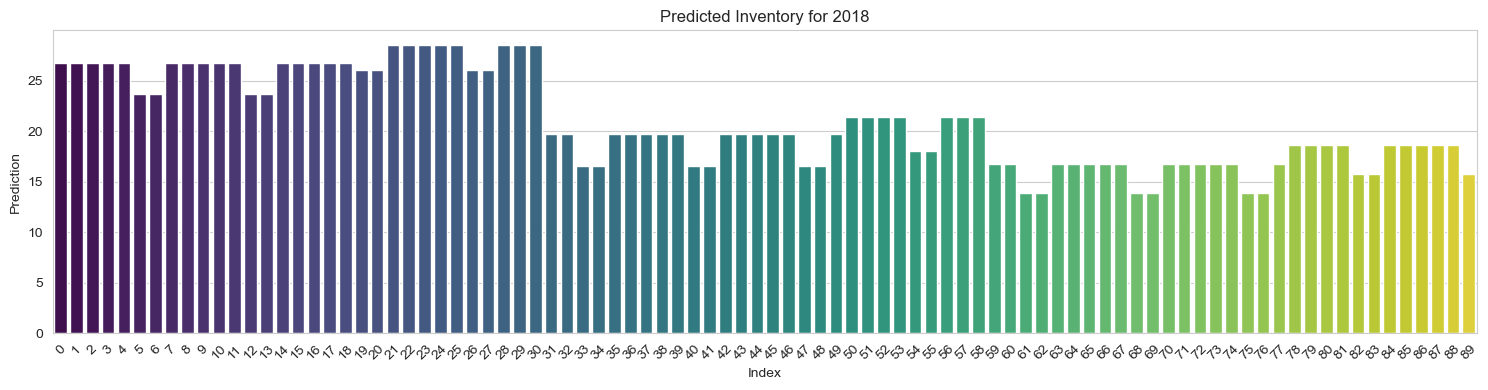

In [45]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming Pred is your data for prediction
scaler = StandardScaler()
Pred = scaler.fit_transform(Pred)

# Predicting with the trained model
Pred_Y = model.predict(Pred)

formatted_pred = np.array2string(Pred_Y, precision=2, separator=', ', suppress_small=True)

# Print the formatted prediction
print("Formatted Prediction:")
print(formatted_pred)
print("Size:", Pred_Y.size)

# Create a seaborn style plot for better visualization
sns.set_style("whitegrid")
plt.figure(figsize=(15, 4))
sns.barplot(x=np.arange(len(Pred_Y)), y=Pred_Y, palette="viridis")
plt.xlabel("Index")
plt.ylabel("Prediction")
plt.title("Predicted Inventory for 2018")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle

# Load the trained machine learning model
model = pickle.load(open('model.pkl', 'rb'))

# Prepare input data for the specific day
specific_day_data = pd.DataFrame({
    'day': [23],          # Specify the day
    'month': [2],         # Specify the month (e.g., January)
    'year': [2018],
    'm1': [np.sin(2 * (2 * np.pi / 12))],  # Sine of the month to capture cyclic nature
    'm2': [np.cos(2 * (2 * np.pi / 12))],  # Cosine of the month to capture cyclic nature
    'weekday': [5],       # Specify the day of the week (0 for Monday, 1 for Tuesday, ..., 6 for Sunday)
    'store': [1],         # Specify the store number
    'item': [1]           # Specify the item number
})

# Standardize the input data
scaler = StandardScaler()
specific_day_data_scaled = scaler.fit_transform(specific_day_data)

# Predict the inventory demand for the specific day
inventory_demand = model.predict(specific_day_data_scaled)

# Print the predicted inventory demand
print("Predicted inventory demand for the specific day of 2018:", inventory_demand)

Predicted inventory demand for the specific day of 2018: [18.35710103]
